# Working with EPA CEMS data

CEMS or <a href='https://www.epa.gov/emc/emc-continuous-emission-monitoring-systems'>**Continusous Emissions Monitoring Systems**</a> are used to track power plant compliance with EPA emission standards. Among the data are hourly measurements of SO2, CO2, and NOx emissions associated with a given plant. The EPA's <a href='https://www.epa.gov/airmarkets'>Clean Air Markets Division</a> has collected CEMS data stretching back to 1990 and publicized it in their <a href='https://ampd.epa.gov/ampd/'>data portal</a>. By combinging the CEMS data with EIA and FERC data, you gain access to greater and more specific information about utilities and generation facilities. This notebook provides a glimpse into the analysis potential of CEMS-EIA data integration.

**NOTE**: This Notebook presuposes access to the parquet files in which the CEMS data is stored.

##### Notebook Contents:
* **<a href='#access'>Accessing CEMS data</a>**
 - <a href='#1subset'>1. Select a subset of raw data using Dask</a>
 - <a href='#2transfer'>2. Transfer desired data to pandas</a>
* **<a href='#manipulating'>Manipulating & Visualizing CEMS data</a>**
 - <a href='#vis_setup'>Visualization Setup</a>
 - <a href='#emap'>1. Simple Choropleth</a>
 - <a href='#pcem'>2. Proportional Coordinates Map</a>
 - <a href=''></a>
 - <a href='#hi_emit'>4. Identify Highest Emittors</a>

### Setup

The following kernels enable interaction with the CEMS dataset through pudl.

In [4]:
# Standard libraries
import logging
import os
import pathlib
import sys

# 3rd party libraries
import geopandas as gpd
import geoplot as gplt
import dask.dataframe as dd
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy as sa


# Local libraries
import pudl

In [5]:
logger=logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [6]:
pudl_settings = pudl.workspace.setup.get_defaults()
#display(pudl_settings)

ferc1_engine = sa.create_engine(pudl_settings['ferc1_db'])
#display(ferc1_engine)

pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
#display(pudl_engine)

#pudl_engine.table_names()
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine)

<a id='access'></a>
## Accessing CEMS data

The CEMS dataset is enormous! It contains hourly emissions data on an hourly basis between YEAR and 2019, meaning that the full dataset is close to a billion rows and takes up 100 GB of space. That's a lot to process when you may only need a fraction for analysis. The following steps will help you access and work with CEMS efficiently.

<a id='1subset'></a>
#### 1. Select a subset of raw data using Dask

Dask is a python package that parallelizes pandas dataframes so that you can access larger-than-memory data. With Dask, you can select the subset of CEMS data that you'd like to analyse *before* loading the data into a dataframe. While in Dask, you can interact with the data as if it were in a pandas dataframe. 

We'll start with a single year and integrate a range of dates below.

In [7]:
# Select a year to observe
year = 2018

# Locate the data for the given year/s on your hard drive.
epacems_path = (pudl_settings['parquet_dir'] + f'/epacems/year={year}')

# Create a Dask object for preliminary data interaction
cems_dd = dd.read_parquet(epacems_path)

Now you can learn things about the data such as column names and datatypes. If you take a look at the length of the Dask dataframe, you'll understand why we're not in pandas yet.

In [5]:
len(cems_dd) # This shows how many rows!!

36768792

In [25]:
cems_dd

,plant_id_eia,unitid,operating_datetime_utc,operating_time_hours,gross_load_mw,steam_load_1000_lbs,so2_mass_lbs,so2_mass_measurement_code,nox_rate_lbs_mmbtu,nox_rate_measurement_code,nox_mass_lbs,nox_mass_measurement_code,co2_mass_tons,co2_mass_measurement_code,heat_content_mmbtu,facility_id,unit_id_epa,state
npartitions=49,,,,,,,,,,,,,,,,,,
,int32,object,"datetime64[ns, UTC]",float32,float32,float32,float32,category[unknown],float32,category[unknown],float32,category[unknown],float32,category[unknown],float32,int32,int32,category[known]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [37]:
cems_dd.columns.tolist()
# For a further information about the contents of each column, see:
#

['plant_id_eia',
 'unitid',
 'operating_datetime_utc',
 'operating_time_hours',
 'gross_load_mw',
 'steam_load_1000_lbs',
 'so2_mass_lbs',
 'so2_mass_measurement_code',
 'nox_rate_lbs_mmbtu',
 'nox_rate_measurement_code',
 'nox_mass_lbs',
 'nox_mass_measurement_code',
 'co2_mass_tons',
 'co2_mass_measurement_code',
 'heat_content_mmbtu',
 'facility_id',
 'unit_id_epa',
 'state']

Now that you know what's available, pick the columns you'd like to work with, and aggregate rows if necessary. Note that the `state` and `measurement_code` columns are categorical datatypes, meaning that they will overwhile your computer's memory if included in the list of columns you'd like to groupby. In pandas, this is solved by including the statement `observed=True` in the groupby, but with Dask we'll solve this by changing the datatype to string.

In [8]:
# A list of the columns you'd like to include in your analysis
my_cols = [
    'state',
    'plant_id_eia', 
    'unitid',
    'so2_mass_lbs', 
    'nox_mass_lbs', 
    'co2_mass_tons',
]

# Select emissions data are grouped by state, plant_id and unit_id
# Remember to change the datatype for 'state' from category to string
my_cems_dd = (
    dd.read_parquet(epacems_path, columns=my_cols)
    .assign(state=lambda x: x['state'].astype('string'))
    .groupby(['plant_id_eia', 'unitid', 'state'])[
         ['so2_mass_lbs', 'nox_mass_lbs', 'co2_mass_tons']]
    .sum())

<a id='2transfer'></a>
#### 2. Transfer desired data to pandas

Now that you've selected the data you want to work with, we'll transfer it to pandas so that all rows are accessible. It'll take a moment to run because there are so many rows.

In [9]:
# Create a pandas dataframe out of your Dask dataframe and add a column to 
# indicate the year the data are coming from.
client = Client()
my_cems_df = (
    client.compute(my_cems_dd)
    .result()
    .assign(year=year)
).reset_index()

/Users/aesharpe/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57250 instead
  warnings.warn(


In [32]:
my_cems_df

,plant_id_eia,unitid,state,so2_mass_lbs,nox_mass_lbs,co2_mass_tons,year
0,3,1,AL,4.387602e+03,3.359935e+04,2.711316e+04,2018
1,3,2,AL,4.505275e+03,3.352140e+04,2.719734e+04,2018
2,3,4,AL,9.941826e+06,2.387703e+06,1.090138e+06,2018
3,3,5,AL,5.288740e+05,2.190419e+06,3.418954e+06,2018
4,3,6A,AL,8.894239e+03,1.161604e+05,8.809064e+05,2018
...,...,...,...,...,...,...,...
4381,56596,001,WY,7.227808e+05,4.361752e+05,1.062854e+06,2018
4382,56609,01,WY,1.845840e+06,1.398574e+06,3.355250e+06,2018
4383,57703,CT01,WY,4.023270e+02,5.226094e+03,3.983930e+04,2018
4384,57703,CT02,WY,4.694410e+02,5.892235e+03,4.648161e+04,2018


To get data from multiple years, run the following code:

In [8]:
years = range(2010, 2019)
multi_year_cems_df = pd.DataFrame()

for yr in years:
    epacems_path = (pudl_settings['parquet_dir'] + f'/epacems/year={yr}')
    cems_dd = (
        dd.read_parquet(epacems_path, columns=my_cols)
        .assign(state=lambda x: x['state'].astype('string'))
        .groupby(['plant_id_eia', 'unitid', 'state'])[
            ['so2_mass_lbs', 'nox_mass_lbs', 'co2_mass_tons']]
        .sum())
    cems_df = (
        client.compute(cems_dd)
        .result()
        .assign(year=yr))
    multi_year_cems_df = pd.concat([multi_year_cems_df, cems_df])

In [ ]:
multi_year_cems_df

<a id='manipulating'></a>
## Manipulating & Visualizing CEMS data

Now that we have access to CEMS in pandas, lets see what we can do!

IDEAS: 
* tons so2/unit of fuel
* tons of so2 / fuel cost
* emissions/ff plant capacity

<a id='vis_setup'></a>
### Visualization Setup

To visualize this data, you'll need to download the US States shapefile from the Census Bureau: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html. Select the file called `cb_2018_us_state_5m.zip`, unzip the file, and record its path for use below.


**EX:** `/Users/name/desktop/cb_2018_us_state_5m/cb_2018_us_state_5m.shp`

##### Prep US Geo-data:

In [10]:
# Grab shapefile - see example above
fp = '/Users/aesharpe/Desktop/cb_2018_us_state_5m/cb_2018_us_state_5m.shp'

# Read the shapefile, change the projection, and make the state column name compatible with
# the CEMS dataframe.
us_map_df = (
    gpd
    .read_file(fp)
    .to_crs("EPSG:3395")
    .rename({'STUSPS': 'state'}, axis=1)
)

<a id='emap'></a>
### 1. Simple Choropleth
##### *Visualizing CEMS data*

Lets start by mapping which states have the highest CO2 emissions from power plants. States with darker colors have higher CO2 emissions reported in 2018.

##### Prep CEMS data:

In [11]:
# Convert lbs to tons for so2 and nox and remove old columns
# Aggregate CEMS data to the state level
cems_map_df = (
    my_cems_df.assign(
        so2_mass_tons=lambda x: x.so2_mass_lbs * 0.0005,
        nox_mass_tons=lambda x: x.nox_mass_lbs * 0.0005
    ).drop(columns=['so2_mass_lbs', 'nox_mass_lbs', 'plant_id_eia'], axis=1)
    .groupby(['state', 'year']).sum(min_count=1)
    .reset_index()
)

##### Combine with Geo-data and Plot:

In [12]:
# Combine CEMS and MAP dataframes
states_cems_gdf = pd.merge(us_map_df, cems_map_df, on='state', how='outer')

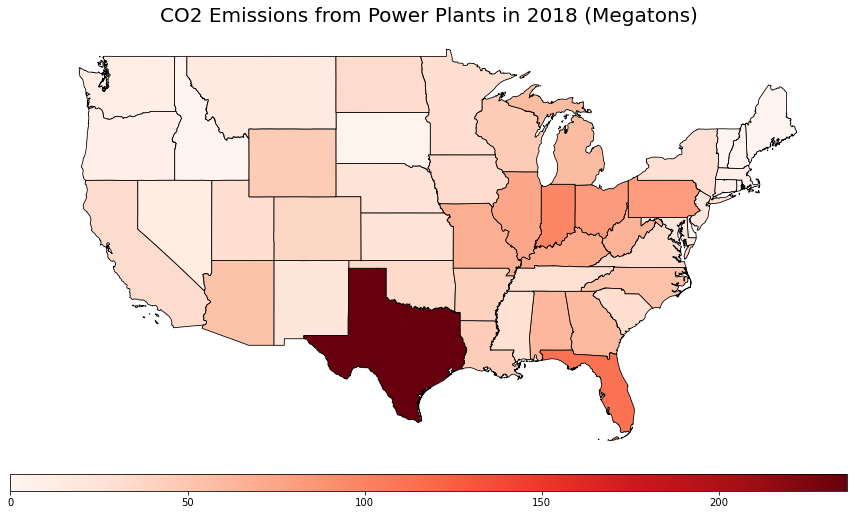

In [13]:
# Add plots for the US, HI, and AK

# The column on which to base the choroplath
choro_col = 'co2_mass_tons'

us_fig, us_ax = plt.subplots(figsize=(15, 10))
#ak_hi_fig, (ak_ax, hi_ax) = plt.subplots(ncols=2)

states_cems_gdf.plot(column=choro_col, cmap='Reds', linewidth=0.8, edgecolor='black', ax=us_ax)
#states_cems_gdf.plot(column=choro_col, cmap='Reds', linewidth=0.8, edgecolor='black', ax=ak_ax)
#states_cems_gdf.plot(column=choro_col, cmap='Reds', linewidth=0.8, edgecolor='black', ax=hi_ax)

us_ax.set_xlim(-1.45e7, -0.7e7) # Used to position US in center of the graph
us_ax.set_ylim(0.25e7, 0.65e7)  # Used to position US in center of the graph
us_ax.set_title('CO2 Emissions from Power Plants in 2018 (Megatons)', fontdict={'fontsize': '20'})
us_ax.axis('off')  # Remove lat and long tick marks
#ak_ax.set_xlim(-2e7, -1.4e7)
#ak_ax.set_ylim(0.6e7, 1.2e7)
#hi_ax.set_xlim(-1.71e7, -1.8e7)
#hi_ax.set_ylim(2e6, 2.6e6)

# Add a legend
vmax = states_cems_gdf[f'{choro_col}'].max() / 1000000 # (convert from tons to megatons)
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=vmax))
sm._A = []
cbar = us_fig.colorbar(sm, orientation="horizontal", pad=0, aspect = 50)

<a id='pcem'></a>
### 2. Proportional Coordinates Map
##### *Integrate CEMS with EIA plant location data*

In order to integreate CEMS with other datasets in pudl, you'll need to start by integrating CEMS with a dataset that also has a field for `plant_id_eia`. If you want to integrate with FERC later on, you'll also want a dataset that has a field for `plant_id_pudl`. Integrating with EIA860 data will also provide plant coordinate for a coordinate map.

##### Prep CEMS data:

In [15]:
# Aggregate CEMS data to the plant level, adjust units for visualization purposes
cems_df = (
    my_cems_df
    .copy()
    .assign(
        co2_mass_mt=lambda df: df.co2_mass_tons / 10000 # measure in 10K tons
    ).drop(columns=['co2_mass_tons'], axis=1)
    .groupby(['plant_id_eia', 'state', 'year'])
    .sum(min_count=1)
    .reset_index()
)

##### Prep EIA data:

In [34]:
# Grab EIA 860 plant data that matched the year selected for CEMS
plants_eia860 = (
    pudl_out.plants_eia860()
    .assign(year=lambda df: df.report_date.dt.year)
    .query("year==2018")
)

##### Combine EIA and CEMS data:

In [16]:
# Combine CEMS and EIA on plant_id_eia, state, and year
eia860_cems_df = (
    pd.merge(plants_eia860, cems_df, on=['plant_id_eia', 'state', 'year'], how='inner')
)

##### Overlay Coordinates on Base Map:

<AxesSubplot:title={'center':'CO2 Emissions from Power Plants in 2018 (10K tons)'}>

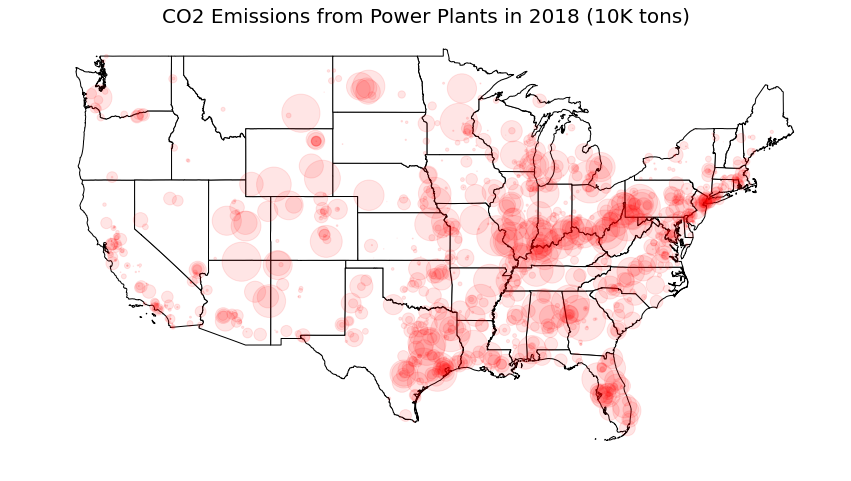

In [17]:
# Make lat and long data cols into plotable points in geopandas
# Make CRS compatile with base map
eia860_cems_gdf = (
    gpd.GeoDataFrame(
        eia860_cems_df, geometry=gpd.points_from_xy(
            eia860_cems_df.longitude, eia860_cems_df.latitude))
    .set_crs(epsg=4326, inplace=True) # necessary step before to_crs(epsg=3395)
    .to_crs(epsg=3395)
)

# Make a base map
us_fig, us_ax = plt.subplots(figsize=(15, 10))

base = us_map_df.plot(color='white', edgecolor='black', ax=us_ax)

us_ax.set_xlim(-1.45e7, -0.7e7) # Used to position US in center of the graph
us_ax.set_ylim(0.25e7, 0.65e7)  # Used to position US in center of the graph
us_ax.set_title('CO2 Emissions from Power Plants in 2018 (10K tons)', fontdict={'fontsize': '20'})
us_ax.axis('off')  # Remove lat and long tick marks

# Plot the coordinates on top of the base map
#eia860_cems_gdf.plot(ax=base, marker='o', color='red', markersize=eia860_cems_df['co2_mass_mt'], alpha=0.1)

eia860_cems_df['alpha_co2'] = eia860_cems_df['co2_mass_mt'] 
eia860_cems_gdf.plot(ax=base, marker='o', color='red', markersize=eia860_cems_df['co2_mass_mt'], alpha=0.1)

<a id='pcem'></a>
### 3. Value-based Heat Map
##### *Integrate CEMS with EIA plant location data*

In [30]:
#eia860_cems_gdf

# us_fig, us_ax = plt.subplots(figsize=(15, 10))

# base = us_map_df.plot(color='white', edgecolor='black', ax=us_ax)

# us_ax.set_xlim(-1.45e7, -0.7e7) # Used to position US in center of the graph
# us_ax.set_ylim(0.25e7, 0.65e7)  # Used to position US in center of the graph
# us_ax.set_title('CO2 Emissions from Power Plants in 2018 (10K tons)', fontdict={'fontsize': '20'})
# us_ax.axis('off')  # Remove lat and long tick marks

# gplt.kdeplot(
#     eia860_cems_gdf['co2_mass_mt'],
#     cmap='Reds',
#     shade=True, shade_lowest=False,
#     clip=eia860_cems_gdf.geometry,
#     ax=base
# )

#gplt.ployplot(eia860_cems_gdf, ax=us_ax)

#https://residentmario.github.io/geoplot/gallery/plot_nyc_collision_factors.html
# based on number of coordinates not values.

<a id='hi_emit'></a>
### 4. Identify Highest Emittors
##### *Integrate CEMS with EIA utility data*

This will create a bar chart to show the utilities contributing to the most CO2 emissions in 2018.

In [96]:
# Find highest polluter
# utility with most polluting plant
# utility with most pollution over 10 year period
# utility with any major drops or increases in pollution levels over the last several years.
# average pollution for coal vs gas plants

##### Prep CEMS:

In [33]:
# Aggregate CEMS data to the plant level, adjust units for visualization purposes
cems_df = (
    my_cems_df
    .copy()
    .groupby(['plant_id_eia', 'state', 'year'])
    .sum(min_count=1)
    .reset_index()
)

##### Prep EIA:

In [37]:
# Prep EIA plant data to given year
plants_eia860 = (
    pudl_out.plants_eia860()
    .assign(year=lambda df: df.report_date.dt.year)
    .query("year==2018")
)

# Merge EIA plant data with EIA utilities data
plants_utils_eia860 = (
    pd.merge(plants_eia860, pudl_out.utils_eia860(), on=['utility_id_pudl', 'state'], how='left') # or utility_id_eia??
)

##### Merge CEMS and EIA Data:

In [97]:
# Merge CEMS and EIA data; groupby utility id (for worst utility)
eia_cems_utils_df = (
    pd.merge(plants_utils_eia860, cems_df, on=['plant_id_eia', 'state', 'year'], how='right')
    .groupby(['utility_id_pudl', 'utility_name_eia'])[['so2_mass_lbs', 'nox_mass_lbs', 'co2_mass_tons']]
    .sum(min_count=1)
    .reset_index()
)

# Merge CEMS and EIA data; no groupby (for utility with worst plant)
eia_cems_utils_df2 = (
    pd.merge(plants_utils_eia860, cems_df, on=['plant_id_eia', 'state', 'year'], how='right')
    .reset_index()
)

##### Plot Data:

AttributeError: 'AxesSubplot' object has no attribute 'barplot'

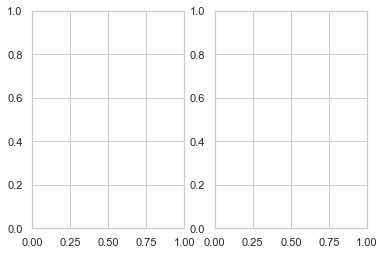

In [98]:
# Grab the top 10 worst CO2 pollutors
top_co2_polluters_df = (
    eia_cems_utils_df
    .sort_values(['co2_mass_tons'], ascending=False)
    .head(10)
)

# Grab top 10 worse plants
worst_co2_plants_df = (
    eia_cems_utils_df2
    .sort_values(['co2_mass_tons'], ascending=False)
    .head(10)
)

# Build a bar chart to show the damage
# plt.figure(figsize=(10,5))
# chart = sns.barplot(
#     data=top_co2_polluters_df,
#     x='utility_name_eia',
#     y='co2_mass_tons',
#     palette='Reds_r', # _r reverses the order of the color palette
# )
# chart.set_xticklabels(chart.get_xticklabels(), horizontalalignment='right', rotation=30)
# chart.set_title('Highest Polluting Utilities in 2018 (CO2)')

# plt.show()
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.barplot()
ax2.barplot()
plt.show()

In [ ]:
plants_utils_eia860

In [185]:
# eia860_cems_df.columns.tolist()
# lat / long
# utility id

# eia860_cems_df.columns.tolist()
# utility name

# pudl_out.fuel_ferc1()
# emissions / (fuel_cost_per_unit_burned * fuel_qty_burned)
# emissions / fuel_qty_burned

# pudl_out.bf_eia923().columns.tolist()
# emissions / fuel_consumed_units

#pudl_out.gens_eia860() 
# emissions / capacity_mw

# capacity / emissions by fuel type as different sized dots.

In [93]:
#pudl_out.gens_eia860()

In [ ]:
# Combine multi-index into regular index, create sum col
# cems_map_df.columns = list(map('_'.join, cems_map_df.columns.values))